## Постановка

В задании необходимо решить две задачи:
- восстановить взаимное расположение двух откалиброванных камер,
- триангулировать точки изображений, восстановив их расположение в пространстве.

Для каждой задачи необходимо выписать аналитическое решение (его можно оформить с помощью LaTeX'а в соседствующих ячейках), а также вычислить его для приведенных данных. Два вывода и два аналитических решения будут иметь одинаковую стоимость при оценки задания.

Что дано?

Два снимка бюста, а также наборы ключевых точек ```points_l``` и ```points_r```. Точке ```points_l[i]``` на левом кадре соответствует точка ```points_r[i]``` на правом кадре. Точки изображения отнормированы так, чтобы находиться в пределах квадрата $[-1, 1]^2$.

# Входные данные

In [1]:
import numpy as np
import torch
import matplotlib.pylab as plt
import open3d as o3d

from typing import Tuple
from jaxtyping import Float
from torch import Tensor

def dehomogenize_points(
    points: Float[Tensor, "batch dim"]
) -> Float[Tensor, "batch dim-1"]:
    return points[..., :-1] / points[..., -1:]


def homogenize_points(
    points: Float[Tensor, "batch dim"]
) -> Float[Tensor, "batch dim+1"]:
    last_coordinate = torch.ones_like(points[..., -1:])
    return torch.cat((points, last_coordinate), dim=-1)


left = plt.imread("left.png")
right = plt.imread("right.png")
concatenated_image = np.concatenate((left, right), axis=1)

# I have mapped the points to [-1, 1]. Point points_l[i] corresponds to points_r[i].
points_l = torch.Tensor(
    [
        [0.1824, -0.9306, 1.0000],
        [0.2833, -0.7148, 1.0000],
        [0.3787, -0.4583, 1.0000],
        [0.3602, -0.2509, 1.0000],
        [0.5157, -0.2213, 1.0000],
        [0.3685, -0.1676, 1.0000],
        [0.5167, -0.1444, 1.0000],
        [0.5556, -0.0111, 1.0000],
        [0.5259, 0.0889, 1.0000],
        [0.3194, 0.3019, 1.0000],
        [0.1278, 0.6565, 1.0000],
        [0.2250, 0.6380, 1.0000],
        [-0.1648, 0.6870, 1.0000],
        [0.3000, 0.6037, 1.0000],
        [-0.0750, 0.9380, 1.0000],
        [0.3519, 0.8259, 1.0000],
    ]
)

points_r = torch.Tensor(
    [
        [-0.1981, -0.9259, 1.0000],
        [-0.2898, -0.7148, 1.0000],
        [-0.3648, -0.4620, 1.0000],
        [-0.5065, -0.2231, 1.0000],
        [-0.3389, -0.2519, 1.0000],
        [-0.5056, -0.1463, 1.0000],
        [-0.3463, -0.1685, 1.0000],
        [-0.5426, -0.0120, 1.0000],
        [-0.5093, 0.0889, 1.0000],
        [-0.3037, 0.3028, 1.0000],
        [-0.2222, 0.6407, 1.0000],
        [-0.1130, 0.6574, 1.0000],
        [-0.3407, 0.6028, 1.0000],
        [0.1630, 0.6796, 1.0000],
        [-0.4028, 0.8120, 1.0000],
        [0.1130, 0.9491, 1.0000],
    ]
)

Если известны внутренние параметры камеры, с помощью которой были сделаны снимки, взаимное расположение этих камер можно восстановить по фундаментальной матрице $F$.

Снимки были получены с камеры с фокусным расстоянием 50 миллиметров, а размер сенсора составлял 36 миллиметров. С учетом этого вычислим калибровочную матрицу камеры, а также фундаментальную матрицу пары снимков.

In [2]:
# camera calibration
f = 50
sensor_size = 36
K = torch.tensor(
    [[2 * f / sensor_size, 0.0, 0.0], [0.0, 2 * f / sensor_size, 0.0], [0.0, 0.0, 1.0]]
)


def get_fundamental_matrix(
    points_l: Float[Tensor, "batch 3"], 
    points_r: Float[Tensor, "batch 3"],
) -> Float[Tensor, "3 3"]:
    equations = torch.einsum(
        "bi,bj->bij",
        points_r,
        points_l,
    ).view(-1, 9)
    u, s, v = torch.linalg.svd(equations)
    F = v[-1].view(3, 3)
    # finds closest rank-2 matrix
    U, S, V = torch.linalg.svd(F)
    F = U @ torch.diag(S * torch.tensor([1, 1, 0])) @ V
    return F


F = get_fundamental_matrix(points_l, points_r)

Визуализируем входные снимки, ключевые точки, а также эпиполярные линии.

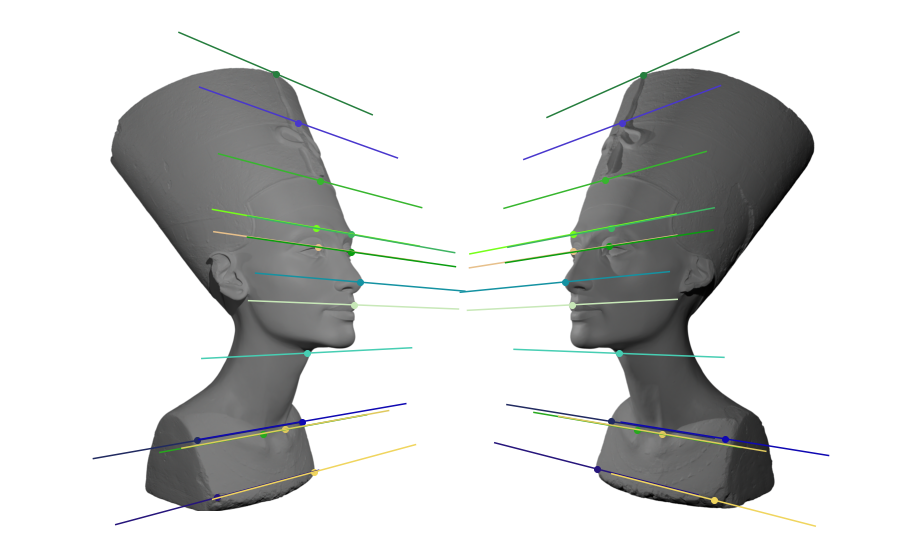

In [3]:
def plot_epipolar_line(ax, F, point_l, point_r, image_size):
    # plot two epipolar lines for a single correspondence
    rotate_90 = torch.tensor([[0.0, -1.0], [1.0, 0.0]])
    line_l = rotate_90 @ dehomogenize_points(F.T @ point_r)
    line_l = line_l / line_l.norm()
    line_r = rotate_90 @ dehomogenize_points(F @ point_l)
    line_r = line_r / line_r.norm()
    # pixel coordinates
    point_l = dehomogenize_points(point_l)
    point_l = (image_size // 2) * (point_l + 1.0)
    point_r = dehomogenize_points(point_r)
    point_r = (image_size // 2) * (point_r + 1.0)
    point_r[0] += image_size
    # compute intervals & point locations
    delta_t = 250
    left_line = torch.stack(
        [point_l[..., :2] - delta_t * line_l, point_l[..., :2] + delta_t * line_l],
        dim=-1,
    )
    right_line = torch.stack(
        [point_r[..., :2] - delta_t * line_r, point_r[..., :2] + delta_t * line_r],
        dim=-1,
    )
    points = torch.stack([point_l, point_r], dim=-1)
    # plot
    c = np.random.rand(1, 3)
    ax.scatter(*points, c=c)
    ax.plot(*left_line, c=c)
    ax.plot(*right_line, c=c)


fig, ax = plt.subplots(figsize=(17, 10))
ax.imshow(concatenated_image)
for point_l, point_r in zip(points_l, points_r):
    plot_epipolar_line(ax, F, point_l, point_r, image_size=1080)
ax.axis("off");

# 1. Вычисление взаимного расположения камер

Расположение памеры задают её внешние параметры: координаты центра и матрица поворота.

Предполагая, что центр левой камеры расположен в точке $(0, 0, 0)^T$, а матрица поворота камеры единичная, мы вывели соотношение для фундаментальной матрицы $F$:
$$ F = K^{-T} [t]_\times R K^{-1}, $$
где вектор $t$ задает координаты центра правой камеры, $R$ матрицу поворота, а обозначение $[t]_\times$ задает матрицу линейного оператора, соответствующего векторному умножению на $t$ слева.

Зная матрицы $F$ и $K$, вычислите значения $R$ и $t$ (с точностью до скалярного множителя). Приведите напишите вывод выражений для них, а также вычислите эти выражения для приведенного примера.

Можно ли как-то проверить найденное решение? Согласуется ли оно со здравым смыслом?

*Решение:* ...

In [ ]:
def get_camera_extrinsics(
    F: Float[Tensor, "3 3"],
    K: Float[Tensor, "3 3"]
) -> Tuple[Float[Tensor, "3 3"], Float[Tensor, "3"]]:
    raise NotImplementedError

R, t = get_camera_extrinsics(F, K)

# 2. Триангуляция точек изображения

Зная взаимное расположение камер, мы можем восстановить трёхмерные координаты точек по парам соответствий на изображениях. Этот процесс называется триангуляцией.

Более формально, нужно для пары соответствующий точек $x_l$ и $x_r$ нужно найти точку $x$, для которой выполнено
$$\begin{cases}
x_l &= P_l x \\
x_r &= P_r x,
\end{cases}
$$
где равенство подразумевается в смысле проективной плоскости. Сведите задачу к системе линейных уравнений, запишите соответствующую систему и найдите численно её решение для каждой данной в задании пары точек. Поскольку для реальных точек равенство не будет выполнено точно, решение стоит искать среди минимальных сингулярных векторов SVD-разложения матрицы системы.

Обратите внимание, реализованная функция должна принимать и возвращать точки, представленные в однородных координатах.

*Решение:* ...


In [ ]:
def get_w2c_matrix(
    R: Float[Tensor, "3 3"],
    t: Float[Tensor, "3"],
) -> Float[Tensor, "4 4"]:
    c_w2c = torch.cat([R, t.unsqueeze(-1)], dim=-1)
    c_w2c = torch.cat([c_w2c, torch.tensor([[0, 0, 0, 1]])], dim=0)
    return c_w2c


def get_projection_matrix(
    K: Float[Tensor, "3 3"],
    R: Float[Tensor, "3 3"],
    t: Float[Tensor, "3"],
) -> Float[Tensor, "3 4"]:
    c_w2c = get_w2c_matrix(R, t)
    return K @ c_w2c[:3]


proj_l = get_projection_matrix(K, torch.eye(3), torch.zeros(3))
proj_r = get_projection_matrix(K, R, t)

In [ ]:
def get_point(
    point_l: Float[Tensor, "3"], 
    proj_l: Float[Tensor, "3 4"], 
    point_r: Float[Tensor, "3"],
    proj_r: Float[Tensor, "3 4"],
) ->  Float[Tensor, "4"]:
    raise NotImplementedError

In [ ]:
points = []
for point_l, point_r in zip(points_l, points_r):
    points += [
        get_point(point_l, proj_l, point_r, proj_r),
    ]

points = torch.stack(points, dim=0)

In [ ]:
def plot_points(ax, points_l, proj_l, points_r, proj_r, points, image_size):
    # left
    points_l = dehomogenize_points(points_l)
    points_l = image_size // 2 * (points_l + 1.0)
    ax.scatter(*points_l.T, label="Keypoints $l$")
    # right
    points_r = dehomogenize_points(points_r)
    points_r = image_size // 2 * (points_r + 1.0)
    points_r[..., 0] += image_size
    ax.scatter(*points_r.T, label="Keypoints $r$")
    # projected_left
    points_l_proj = dehomogenize_points(points @ proj_l.T)
    points_l_proj = image_size // 2 * (points_l_proj + 1.0)
    ax.scatter(*points_l_proj.T, label="Projected points $l$")
    # projected_right
    points_r_proj = dehomogenize_points(points @ proj_r.T)
    points_r_proj = image_size // 2 * (points_r_proj + 1.0)
    points_r_proj[..., 0] += image_size
    ax.scatter(*points_r_proj.T, label="Projected points $r$")


fig, ax = plt.subplots(figsize=(17, 10))
ax.imshow(concatenated_image)
plot_points(ax, points_l, proj_l, points_r, proj_r, points, 1080)
ax.legend()
ax.axis("off")

# Восстановление облака точек (вне зачета)

Среди входных данных для задания также можно найти карты глубины для каждого изображения. Однако, как это часто бывает, масштаб карты глубины не сохранился, все значения глубин были отображены в отрезок $[0, 1]$. Подумайте, как можно было бы восстановить масштаб карт глубин? Это позволило бы восстановить облако точек по каждому из изображений, а информация о взаимном расположении камер позволила бы объединить облака точек с нескольких ракурсов.

In [ ]:
normalized_depth_left = torch.tensor(plt.imread("left_depth.png"))[..., :1]
normalized_depth_right = torch.tensor(plt.imread("right_depth.png"))[..., :1]
mask_left = torch.tensor(plt.imread("left_depth.png"))[..., -1:]
mask_right = torch.tensor(plt.imread("right_depth.png"))[..., -1:]


def get_point_cloud(depthmap, mask, K, c_w2c):
    x = torch.linspace(-1.0, 1.0, 256)
    xs, ys = torch.meshgrid(x, x, indexing="xy")
    image_points = torch.stack([xs, ys], dim=-1)
    # get depth & mask values at grid points
    depths = torch.nn.functional.grid_sample(
        torch.permute(depthmap, (2, 0, 1)).unsqueeze(0),
        image_points.view(1, 1, -1, 2),
        align_corners=True,
    ).view(-1, 1)
    observed_points = (
        torch.nn.functional.grid_sample(
            torch.permute(mask, (2, 0, 1)).unsqueeze(0),
            image_points.view(1, 1, -1, 2),
            align_corners=True,
        ).view(-1)
        > 0.95
    )
    # remove empty space
    depths = depths[observed_points]
    image_points = image_points.view(-1, 2)[observed_points]
    # get 3d points
    point_cloud = depths * homogenize_points(image_points) @ torch.linalg.inv(K).T
    point_cloud = homogenize_points(point_cloud) @ torch.linalg.inv(c_w2c).T
    return dehomogenize_points(point_cloud).view(-1, 3)

Предложенное решение можно реализовать, заменив нормированную карту глубин ```normalized_depth_map_{left,right}``` на карту глубины в подходящем масштабе, а затем визуализировать восстановленное облако точек с помощью приведенных ниже ячеек.

In [ ]:
c_w2c_left = get_w2c_matrix(torch.eye(3), torch.zeros(3))
pc_left = get_point_cloud(normalized_depth_left, mask_left, K, c_w2c_left)

c_w2c_right = get_w2c_matrix(R, t)
pc_right = get_point_cloud(normalized_depth_right, mask_right, K, c_w2c_right)

pc_merged = torch.cat([pc_left, pc_right], dim=0).detach().numpy()

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc_merged)
o3d.io.write_point_cloud("./data.ply", pcd)
o3d.visualization.draw_geometries([pcd])